/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/setuptools/_distutils/_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(


Primeros ruidos: [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337]
Simulando modelo exacto del paper...


(0.0, 1000.0)

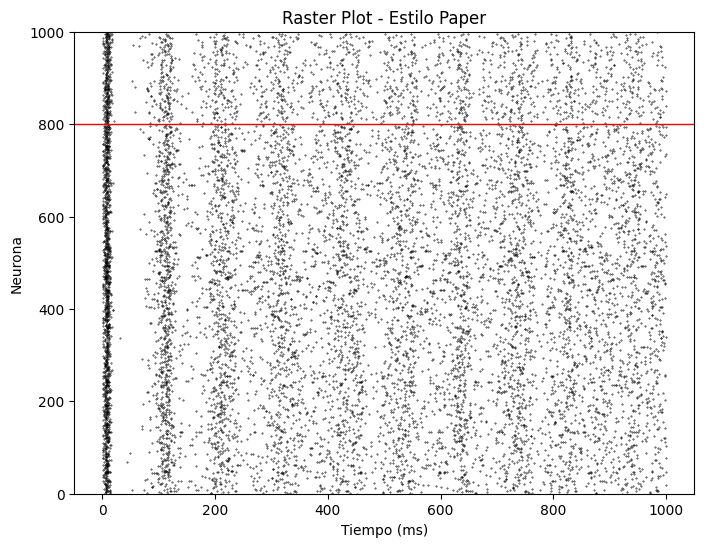

In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
print("Primeros ruidos:", np.random.randn(5))

start_scope()
# magic_network.schedule = ['start', 'groups', 'synapses', 'thresholds', 'resets', 'end']
defaultclock.dt = 0.01*ms  # Timestep global

# Parámetros exactos del paper
N_exc = 800  # 80% de 1000 neuronas como en el código MATLAB
N_inh = 200  # 20% de 1000 neuronas
N_total = N_exc + N_inh

# Ecuaciones exactas del paper
equations = '''
dv/dt = (0.04*v**2 + 5*v + 140 - u + I_syn + I_thalamic)/ms : 1
du/dt = a*(b*v - u)/ms : 1 
I_syn : 1
I_thalamic: 1
a : 1
b : 1  
c : 1
d : 1
'''

# Crear grupos separados
exc_neurons = NeuronGroup(N_exc, equations, 
                          threshold='v >= 30',
                          reset='v = c; u += d',
                          method='euler')

inh_neurons = NeuronGroup(N_inh, equations,
                          threshold='v >= 30', 
                          reset='v = c; u += d',
                          method='euler')

# Input talámico exacto del paper: I = [5*randn(Ne,1); 2*randn(Ni,1)]
# Cada ms, cada neurona recibe input Gaussiano
# @network_operation(dt=1*ms)
# def update_input():
#     # Input gaussiano para neuronas excitatorias
#     exc_neurons.I_thalamic = 5 * np.random.randn(N_exc)
#     # Input gaussiano para neuronas inhibitorias  
#     inh_neurons.I_thalamic = 2.5 * np.random.randn(N_inh)

@network_operation(dt=1*ms)
def update_input():
    # Input gaussiano para neuronas excitatorias
    exc_neurons.I_thalamic = 2 * np.random.poisson(1.5, N_exc)
    # Input gaussiano para neuronas inhibitorias  
    inh_neurons.I_thalamic = 1 * np.random.poisson(1.0, N_inh)
    
#Input de Poisson para excitatorias
# poisson_exc = PoissonInput(exc_neurons, 'I_thalamic', 1, rate=2*Hz, weight=5.0)

# # Input de Poisson para inhibitorias  
# poisson_inh = PoissonInput(inh_neurons, 'I_thalamic', 1, rate=2*Hz, weight=2.0)

# Heterogeneidad EXACTA del paper
r_exc = np.random.rand(N_exc)
r_inh = np.random.rand(N_inh)

# Excitatorias: (a,b) = (0.02, 0.2), (c,d) = (-65, 8) + (15, -6)r²
exc_neurons.a = 0.02
exc_neurons.b = 0.2
exc_neurons.c = -65 + 15 * r_exc**2
exc_neurons.d = 8 - 6 * r_exc**2

# Inhibitorias: (a,b) = (0.02, 0.25) + (0.08, -0.05)r, (c,d) = (-65, 2)
inh_neurons.a = 0.02 + 0.08 * r_inh
inh_neurons.b = 0.25 - 0.05 * r_inh
inh_neurons.c = -65
inh_neurons.d = 2

# Condiciones iniciales
exc_neurons.v = -65 + 10*np.random.randn(N_exc) 
exc_neurons.u = exc_neurons.b * exc_neurons.v
inh_neurons.v = -65 + 10*np.random.randn(N_inh) 
inh_neurons.u = inh_neurons.b * inh_neurons.v

# u se actualiza cada 1ms
# exc_neurons.run_regularly('u += a*(b*v - u)', dt=1*ms)

# CONECTIVIDAD exacta del paper
# Matriz S: [0.5*rand(Ne+Ni,Ne), -rand(Ne+Ni,Ni)]

# Reset sinapsis
exc_neurons.run_regularly('I_syn = 0', when='before_synapses', dt = 1.0*ms)
inh_neurons.run_regularly('I_syn = 0', when='before_synapses', dt = 1.0*ms)

k = 5.0
# 1. Excitatorias -> Excitatorias
syn_ee = Synapses(exc_neurons, exc_neurons, 'w : 1', on_pre='I_syn += w')
syn_ee.connect(p=0.1)
syn_ee.w = 'k/2.0 * rand()'
syn_ee.delay = '1.0*ms'

# 2. Excitatorias -> Inhibitorias  
syn_ei = Synapses(exc_neurons, inh_neurons, 'w : 1', on_pre='I_syn += w')
syn_ei.connect(p=0.1)
syn_ei.w = 'k/2.0 * rand()'
syn_ei.delay = '1.0*ms'

# 3. Inhibitorias -> Excitatorias
syn_ie = Synapses(inh_neurons, exc_neurons, 'w : 1', on_pre='I_syn += w')
syn_ie.connect(p=0.1)
syn_ie.w = '-k*rand()'
syn_ie.delay = '1.0*ms'

# 4. Inhibitorias -> Inhibitorias
syn_ii = Synapses(inh_neurons, inh_neurons, 'w : 1', on_pre='I_syn += w')
syn_ii.connect(p=0.1)
syn_ii.w = '-k*rand()'
syn_ii.delay = '1.0*ms'

# Monitoreo
spike_mon_exc = SpikeMonitor(exc_neurons)
spike_mon_inh = SpikeMonitor(inh_neurons)
state_mon_exc = StateMonitor(exc_neurons, ['v'], record=range(0, min(100, N_exc), 1))
state_mon_inh = StateMonitor(inh_neurons, ['v'], record=range(0, min(100, N_exc), 1))

# Monitores de corriente sináptica (que ya tienes)
I_synaptic_exc_mon = StateMonitor(exc_neurons, 'I_syn', record=True)
I_synaptic_inh_mon = StateMonitor(inh_neurons, 'I_syn', record=True)

I_thalamic_exc_mon = StateMonitor(exc_neurons, 'I_thalamic', record=True)
I_thalamic_inh_mon = StateMonitor(inh_neurons, 'I_thalamic', record=True)

print("Simulando modelo exacto del paper...")
run(1000*ms)

# Análisis como en el paper
figure(figsize=(8, 6))

# 1. Raster plot estilo paper
subplot(1, 1, 1)
plot(spike_mon_exc.t/ms, spike_mon_exc.i, '.k', markersize=0.7)
plot(spike_mon_inh.t/ms, spike_mon_inh.i + N_exc, '.k', markersize=0.7)
axhline(y=N_exc, color='r', linestyle='-', linewidth=1)
xlabel('Tiempo (ms)')
ylabel('Neurona')
title('Raster Plot - Estilo Paper')
ylim(0, N_total)

(0.0, 1000.0)

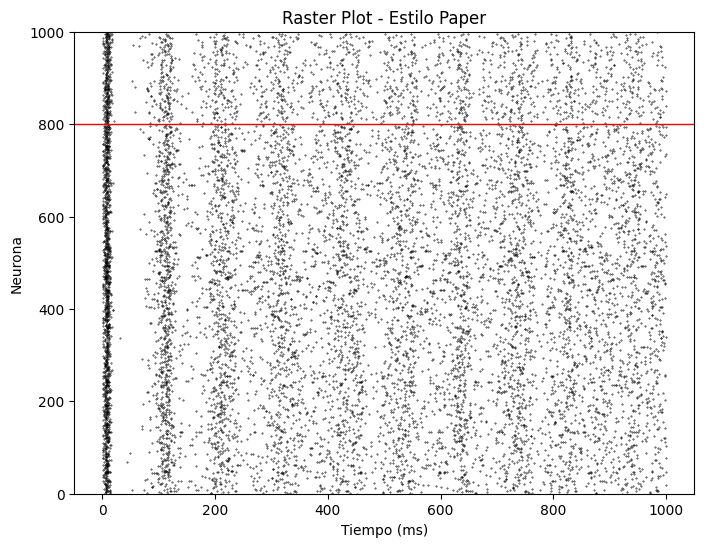

In [2]:
# Análisis como en el paper
figure(figsize=(8, 6))

# 1. Raster plot estilo paper
subplot(1, 1, 1)

all_spikes = np.concatenate((spike_mon_exc.i, spike_mon_inh.i))

patterm = np.unique(all_spikes)

plot(spike_mon_exc.t/ms, spike_mon_exc.i, '.k', markersize=0.7)
plot(spike_mon_inh.t/ms, spike_mon_inh.i + N_exc, '.k', markersize=0.7)
axhline(y=N_exc, color='r', linestyle='-', linewidth=1)
xlabel('Tiempo (ms)')
ylabel('Neurona')
title('Raster Plot - Estilo Paper')
ylim(0, N_total)

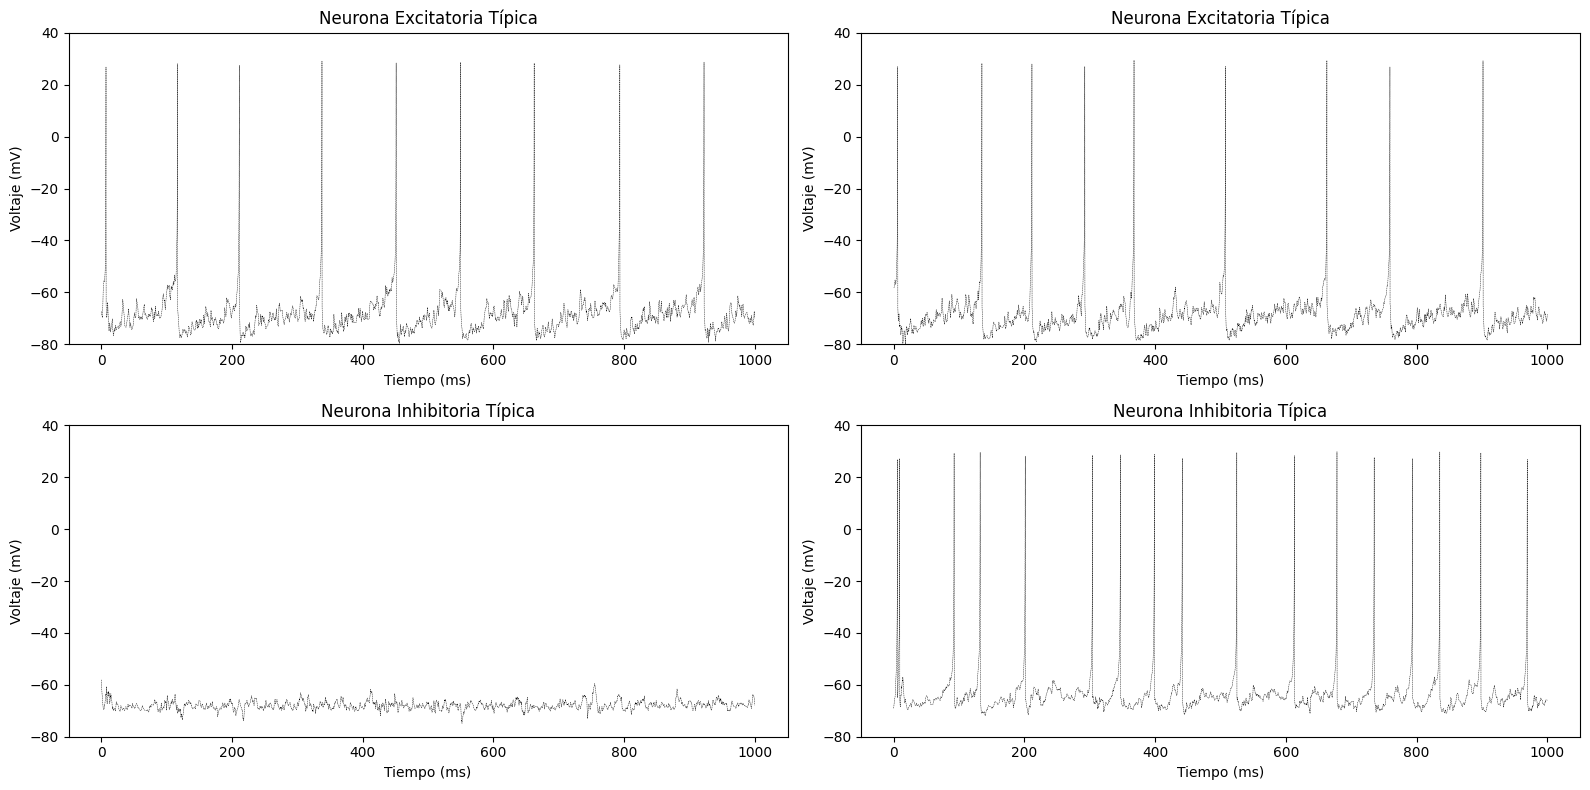

In [3]:
figure(figsize=(16, 8))

# 2. Voltaje de neurona típica
subplot(2, 2, 1)
neuron_idx = 0
plot(state_mon_exc.t/ms, state_mon_exc.v[neuron_idx],'--', linewidth=0.3, color = 'black')
xlabel('Tiempo (ms)')
ylabel('Voltaje (mV)')
title('Neurona Excitatoria Típica')
ylim(-80, 40)

subplot(2, 2, 2)
neuron_idx = 99
plot(state_mon_exc.t/ms, state_mon_exc.v[neuron_idx], '--', linewidth=0.3, color = 'black')
xlabel('Tiempo (ms)')
ylabel('Voltaje (mV)')
title('Neurona Excitatoria Típica')
ylim(-80, 40)

subplot(2, 2, 3)
neuron_idx = 0
plot(state_mon_inh.t/ms, state_mon_inh.v[neuron_idx], '--', linewidth=0.3, color = 'black')
xlabel('Tiempo (ms)')
ylabel('Voltaje (mV)')
title('Neurona Inhibitoria Típica')
ylim(-80, 40)

subplot(2, 2, 4)
neuron_idx = 50
plot(state_mon_inh.t/ms, state_mon_inh.v[neuron_idx], '--', linewidth=0.3, color = 'black')
xlabel('Tiempo (ms)')
ylabel('Voltaje (mV)')
title('Neurona Inhibitoria Típica')
ylim(-80, 40)

tight_layout()

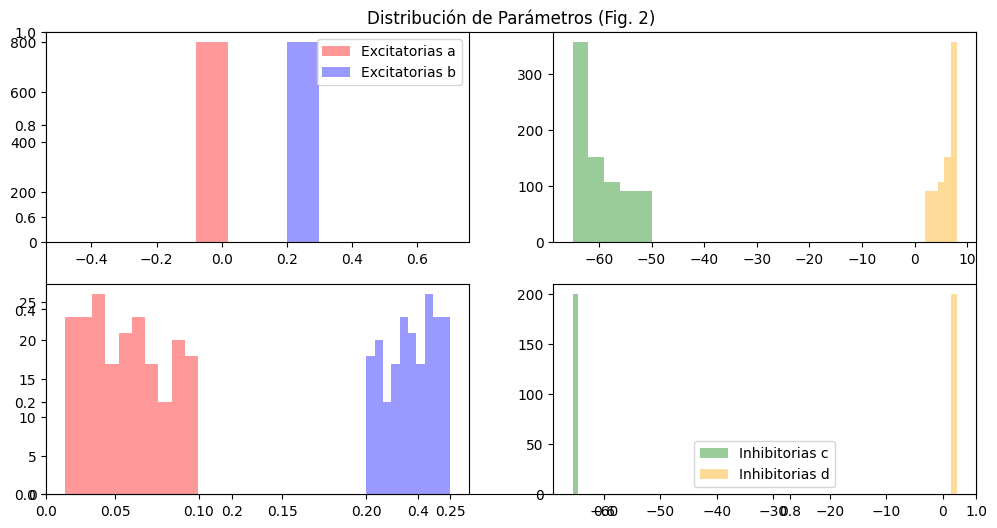

In [4]:
figure(figsize=(12, 6))

title('Distribución de Parámetros (Fig. 2)')
# 3. Distribución de parámetros c,d (como Fig. 2 del paper)
subplot(2, 2, 1)
hist(exc_neurons.a, alpha=0.4, color='red', bins= 10, label='Excitatorias a')
hist(exc_neurons.b, alpha=0.4, color='blue', bins= 10,label='Excitatorias b')
legend()
subplot(2, 2, 2)
hist(exc_neurons.c, alpha=0.4, color='green', bins= 5,label='Excitatorias c')
hist(exc_neurons.d, alpha=0.4, color='orange', bins= 5,label='Excitatorias d')

subplot(2, 2, 3)
hist(inh_neurons.a, alpha=0.4, color='red', bins= 10,label='Inhibitorias a')
hist(inh_neurons.b, alpha=0.4, color='blue', bins= 10,label='Inhibitorias b')
subplot(2, 2, 4)
hist(inh_neurons.c, alpha=0.4, color='green', bins= 1,label='Inhibitorias c')
hist(inh_neurons.d, alpha=0.4, color='orange', bins= 1,label='Inhibitorias d')


legend()

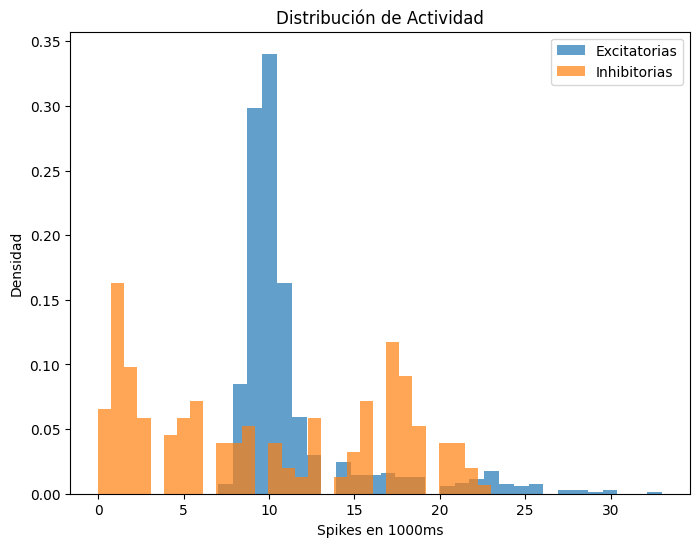

In [5]:
figure(figsize=(8, 6))
# 4. Histograma de frecuencias
subplot(1,1,1)
freq_exc = []
freq_inh = []

for i in range(N_exc):
    spike_count = sum(spike_mon_exc.i == i)
    freq_exc.append(spike_count)

for i in range(N_inh):
    spike_count = sum(spike_mon_inh.i == i) 
    freq_inh.append(spike_count)

hist(freq_exc, bins=30, alpha=0.7, density=True, label='Excitatorias')
hist(freq_inh, bins=30, alpha=0.7, density=True, label='Inhibitorias')
xlabel('Spikes en 1000ms')
ylabel('Densidad')
title('Distribución de Actividad')
legend()

Text(0.5, 1.0, 'Actividad de Red')

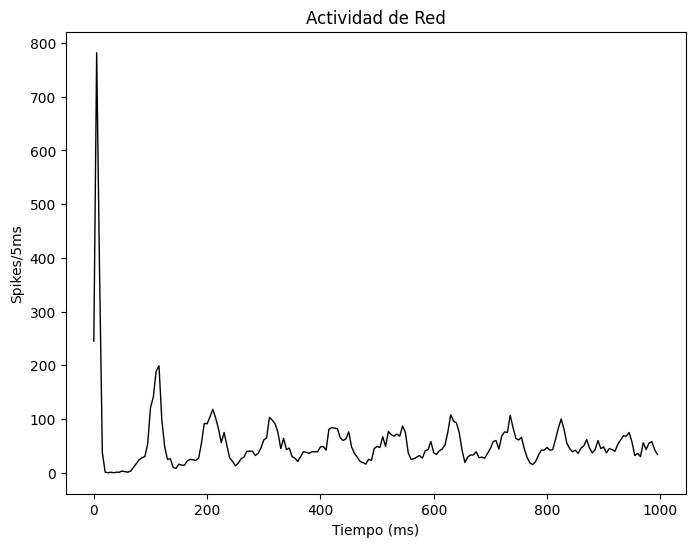

In [6]:
figure(figsize=(8, 6))

# 5. Actividad poblacional (como Fig. 3 del paper)
subplot(1, 1, 1)
bin_size = 5*ms
time_bins = np.arange(0, 1000, bin_size/ms)
activity = []

for t in time_bins:
    total_spikes = (sum((spike_mon_exc.t >= t*ms) & (spike_mon_exc.t < (t + bin_size/ms)*ms)) +
                   sum((spike_mon_inh.t >= t*ms) & (spike_mon_inh.t < (t + bin_size/ms)*ms)))
    activity.append(total_spikes)

plot(time_bins, activity, 'k-', linewidth=1)
xlabel('Tiempo (ms)')
ylabel(f'Spikes/{bin_size/ms:.0f}ms')
title('Actividad de Red')

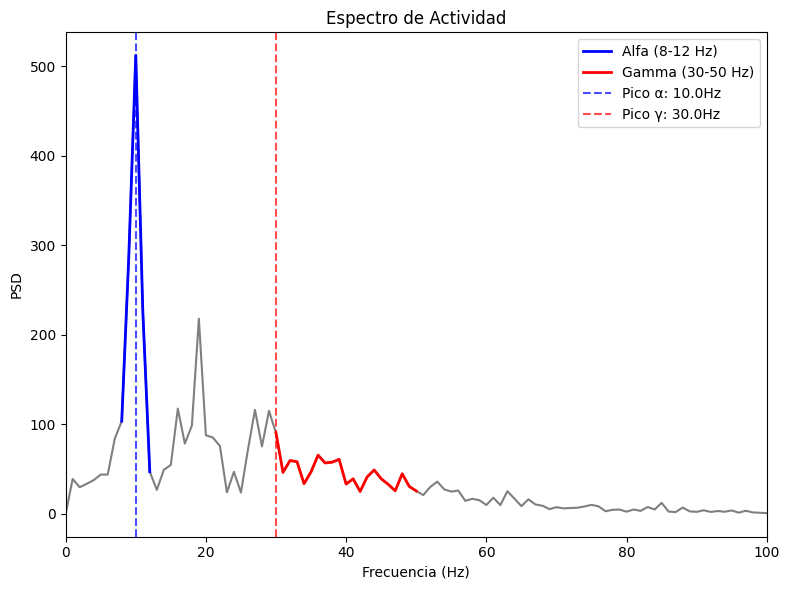

In [7]:
figure(figsize=(8, 6))

subplot(1, 1, 1)

# 6. Análisis espectral simple
from scipy import signal
if len(activity) > 100:

    freqs, psd = signal.periodogram(activity, fs=1000/(bin_size/ms))
    
    # Resaltar bandas específicas
    alpha_band = (freqs >= 8) & (freqs <= 12)
    gamma_band = (freqs >= 30) & (freqs <= 50)
    
    plot(freqs, psd, 'k-', alpha=0.5)
    plot(freqs[alpha_band], psd[alpha_band], 'b-', linewidth=2, label='Alfa (8-12 Hz)')
    plot(freqs[gamma_band], psd[gamma_band], 'r-', linewidth=2, label='Gamma (30-50 Hz)')
    
    # Verificar que las bandas tengan datos
    if np.any(alpha_band) and np.any(gamma_band):
        alpha_peak = freqs[alpha_band][np.argmax(psd[alpha_band])]
        gamma_peak = freqs[gamma_band][np.argmax(psd[gamma_band])]
    
    # Usar ymax dinámico en lugar de 1e6 fijo
    ymax = np.max(psd) * 1.1
    axvline(alpha_peak, color='blue', linestyle='--', alpha=0.7, label=f'Pico α: {alpha_peak:.1f}Hz')
    axvline(gamma_peak, color='red', linestyle='--', alpha=0.7, label=f'Pico γ: {gamma_peak:.1f}Hz')

    
    xlabel('Frecuencia (Hz)')
    ylabel('PSD')
    title('Espectro de Actividad')
    xlim(0, 100)

legend()
tight_layout()
show()

In [8]:
# Estadísticas exactas como en el paper
print(f"\n{'='*60}")
print("COMPARACIÓN CON PAPER ORIGINAL")
print(f"{'='*60}")
print(f"Arquitectura:")
print(f"  Neuronas: {N_exc} exc + {N_inh} inh (ratio 4:1 ✓)")
print(f"  Conexiones: {len(syn_ee.i) + len(syn_ii.i)+ len(syn_ie.i)+ len(syn_ei.i)} totales")
print(f"  Prob. conexión: {N_total*N_total/(N_total*N_total):.3f} (paper: ~0.09)")

print(f"\nActividad:")
total_spikes_exc = len(spike_mon_exc.t)
total_spikes_inh = len(spike_mon_inh.t)
mean_freq_exc = total_spikes_exc / N_exc  # spikes por neurona en 1s
mean_freq_inh = total_spikes_inh / N_inh

print(f"  Freq. excitatorias: {mean_freq_exc:.1f} Hz (paper: ~8Hz)")
print(f"  Freq. inhibitorias: {mean_freq_inh:.1f} Hz")
print(f"  Spikes totales: {total_spikes_exc + total_spikes_inh}")

print(f"\nParámetros (verificación aleatoria):")
idx = np.random.randint(0, N_exc)
print(f"  Neurona exc #{idx}: c={exc_neurons.c[idx]:.1f}, d={exc_neurons.d[idx]:.1f}")
idx = np.random.randint(0, N_inh)  
print(f"  Neurona inh #{idx}: a={inh_neurons.a[idx]:.3f}, b={inh_neurons.b[idx]:.3f}")

print(f"\nComportamiento emergente:")
asynchrony = np.std(activity) / np.mean(activity)
print(f"  Índice asincronía: {asynchrony:.2f} (>1 = asíncrono ✓)")
active_exc = sum(np.array(freq_exc) > 0)
print(f"  Neuronas activas: {active_exc}/{N_exc} ({100*active_exc/N_exc:.1f}%)")


COMPARACIÓN CON PAPER ORIGINAL
Arquitectura:
  Neuronas: 800 exc + 200 inh (ratio 4:1 ✓)
  Conexiones: 100305 totales
  Prob. conexión: 1.000 (paper: ~0.09)

Actividad:
  Freq. excitatorias: 11.3 Hz (paper: ~8Hz)
  Freq. inhibitorias: 9.7 Hz
  Spikes totales: 10987

Parámetros (verificación aleatoria):
  Neurona exc #81: c=-58.9, d=5.6
  Neurona inh #175: a=0.082, b=0.211

Comportamiento emergente:
  Índice asincronía: 1.19 (>1 = asíncrono ✓)
  Neuronas activas: 800/800 (100.0%)


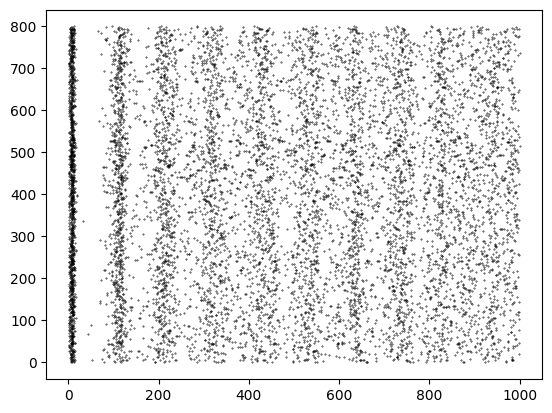

In [9]:
plt.plot(spike_mon_exc.t/ms, spike_mon_exc.i, '.k', markersize=0.7)

In [10]:
# Datos Brian2 (transponer para tener shape (timesteps, neuronas))
I_thal_exc_brian = I_thalamic_exc_mon.I_thalamic         # (1000, 800)
I_thal_inh_brian = I_thalamic_inh_mon.I_thalamic        # (1000, 200)
I_syn_exc_brian = I_synaptic_exc_mon.I_syn   # (1000, 800)
I_syn_inh_brian = I_synaptic_inh_mon.I_syn   # (1000, 200)
I_tot_exc_brian = I_thal_exc_brian + I_syn_exc_brian
I_tot_inh_brian = I_thal_inh_brian + I_syn_inh_brian

stats_brian = {
    'thalamic_exc': {
        'mean_per_neuron': np.mean(I_thal_exc_brian, axis=0),
        'std_per_neuron': np.std(I_thal_exc_brian, axis=0),
        'mean_per_timestep': np.mean(I_thal_exc_brian, axis=1),
        'min_per_timestep': np.min(I_thal_exc_brian, axis=1),
        'max_per_timestep': np.max(I_thal_exc_brian, axis=1)
    },
    'synaptic_exc': {
        'mean_per_neuron': np.mean(I_syn_exc_brian, axis=0),
        'std_per_neuron': np.std(I_syn_exc_brian, axis=0),
        'mean_per_timestep': np.mean(I_syn_exc_brian, axis=1),
        'min_per_timestep': np.min(I_syn_exc_brian, axis=1),
        'max_per_timestep': np.max(I_syn_exc_brian, axis=1)
    },
    'total_exc': {
        'mean_per_neuron': np.mean(I_tot_exc_brian, axis=0),
        'std_per_neuron': np.std(I_tot_exc_brian, axis=0),
        'mean_per_timestep': np.mean(I_tot_exc_brian, axis=1),
        'min_per_timestep': np.min(I_tot_exc_brian, axis=1),
        'max_per_timestep': np.max(I_tot_exc_brian, axis=1)
    },
    'thalamic_inh': {
        'mean_per_neuron': np.mean(I_thal_inh_brian, axis=0),
        'std_per_neuron': np.std(I_thal_inh_brian, axis=0),
        'mean_per_timestep': np.mean(I_thal_inh_brian, axis=1),
        'min_per_timestep': np.min(I_thal_inh_brian, axis=1),
        'max_per_timestep': np.max(I_thal_inh_brian, axis=1)
    },
    'synaptic_inh': {
        'mean_per_neuron': np.mean(I_syn_inh_brian, axis=0),
        'std_per_neuron': np.std(I_syn_inh_brian, axis=0),
        'mean_per_timestep': np.mean(I_syn_inh_brian, axis=1),
        'min_per_timestep': np.min(I_syn_inh_brian, axis=1),
        'max_per_timestep': np.max(I_syn_inh_brian, axis=1)
    },
    'total_inh': {
        'mean_per_neuron': np.mean(I_tot_inh_brian, axis=0),
        'std_per_neuron': np.std(I_tot_inh_brian, axis=0),
        'mean_per_timestep': np.mean(I_tot_inh_brian, axis=1),
        'min_per_timestep': np.min(I_tot_inh_brian, axis=1),
        'max_per_timestep': np.max(I_tot_inh_brian, axis=1)
    }
}

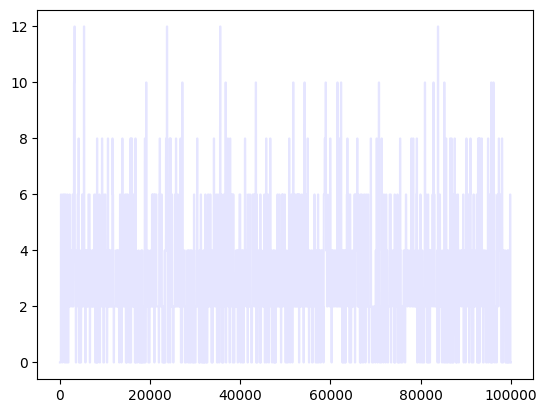

In [11]:
plt.plot(range(0,100000), I_thal_exc_brian[0, :].T, color='blue', alpha=0.1)

In [12]:
# Comparar medias
print("=== INPUT TALÁMICO ===")

print(f"Brian2 exc - Media por neurona: {np.mean(stats_brian['thalamic_exc']['mean_per_neuron']):.4f}")

print(f"Brian2 exc - Std por neurona: {np.mean(stats_brian['thalamic_exc']['std_per_neuron']):.4f}")

print("\n=== INPUT SINÁPTICO ===")

print(f"Brian2 exc - Media: {np.mean(stats_brian['synaptic_exc']['mean_per_neuron']):.4f}")

print(f"Brian2 exc - Std: {np.mean(stats_brian['synaptic_exc']['std_per_neuron']):.4f}")

# Rangos de variación

print(f"Brian2 exc - Rango típico: [{np.mean(stats_brian['synaptic_exc']['min_per_timestep']):.2f}, {np.mean(stats_brian['synaptic_exc']['max_per_timestep']):.2f}]")

=== INPUT TALÁMICO ===
Brian2 exc - Media por neurona: 3.0014
Brian2 exc - Std por neurona: 2.4461

=== INPUT SINÁPTICO ===
Brian2 exc - Media: 0.3213
Brian2 exc - Std: 1.0365
Brian2 exc - Rango típico: [-9.02, 17.64]


In [13]:
print("Brian2 E→E:", np.mean(syn_ee.w), np.std(syn_ee.w))
print("Brian2 I→E:", np.mean(syn_ie.w), np.std(syn_ie.w))

Brian2 E→E: 1.2498973630180592 0.7230990998594962
Brian2 I→E: -2.5120920736974233 1.4477712359151087


In [14]:
# Brian2 - del SpikeMonitor
brian_spikes_per_ms = np.array(spike_mon_exc.t/ms, dtype=int64)
print("Brian2 spikes/ms:", np.mean(brian_spikes_per_ms), np.max(brian_spikes_per_ms))

Brian2 spikes/ms: 460.3775149237232 999


In [15]:
# También verificar si el input se acumula entre timesteps:
print("I_syn timestep 0:", state_mon_Isyn.I_syn[0, 0])
print("I_syn timestep 1:", state_mon_Isyn.I_syn[0, 1]) 
print("I_syn timestep 2:", state_mon_Isyn.I_syn[0, 2])

NameError: name 'state_mon_Isyn' is not defined